# DDPLKO Moduł 5 - praca domowa - Transfer Learning

To piąta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] wybór zbioru danych:
  - [ ] RESISC45 (https://www.tensorflow.org/datasets/catalog/resisc45) - w pytorchu możesz wczytać po rozpakowaniu lub skorzystać z TFDS jak w lekcji (w przypadku ograniczonych zasobów wybierz 10 klas z tego zbioru)
  - [ ] RSCM (http://vcc.szu.edu.cn/research/2017/RSCM.html download link: http://vcc.szu.edu.cn/file/upload_file/0/58/weboem_informations/classification.zip)
  - [ ] własny problem ze zdjeciami (najlepiej) RGB o wymiarach >=224px, minimum 4 klasy, minimum 1000 zdjęć
- [ ] Podziel zbiór w stosunku train:val 70:30 (stratified)
- [ ] Wykonaj krótką prezentację danych - liczebności, przykłady
- [ ] Wybierz framework - TensorFlow bądź PyTorch
- [ ] Wybierz pretrenowany model - skorzystaj z jednego z repozytoriów modeli
- [ ] Zaprezentuj summary dla modelu
- [ ] Przygotuj model - zamroź wagi oprócz klasyfikatora
- [ ] Zaprezentuj summary dla modelu z zamrożonymi wagami
- [ ] W treningach zapisuj wyniki do TensorBoarda
- [ ] Wykonaj trening zamrażając warstwy ekstrkcji cech
- [ ] Wykonaj fine-tuning całej sieci lub większego fragmentu (nie tylko klasyfikator)
- [ ] Udostępnij screenshot z TB na Discordzie `#klasyfikacja-wyniki` (val acc)

Możesz (czyli opcjonalne rzeczy):
- wybrać mały model typu np. MobileNet
- Wykonać eksperymenty i dobrać optymalizator, LR używając LR Finder oraz LR scheduler
- Sprawdzić więcej niż 1 model
- Sprawdzić dodatkowe warstwy Dense/Linear w klasyfikatorze
- Spróbować treningu bez transfer learningu
- zwizualizować dodatkowo:
  - confussion matrix
  - błędne przypadki

# Zbiór danych

In [11]:
from pathlib import Path
import json
import os
import tensorflow_datasets as tfds
import numpy as np
data_dir = Path('/home/jakub/Documents/deep_learning_course/05/weather_classification')
classes = os.listdir(data_dir)

## Podział zbioru

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2

images = []
labels = []
for cls in classes:
    for img in os.listdir(data_dir / cls):
        images.append(img)
        labels.append(cls)
        
X_train, X_testval, y_train, y_testval = train_test_split(images, labels, test_size=0.3, random_state=42,
                                                         stratify=labels)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42,
                                               stratify=y_testval)

assert len(set(y_val)) == len(set(y_train)) == len(set(y_test))

le = LabelEncoder()
le.fit(classes)
classes = le.classes_.tolist()

y_train = le.transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

annotations = {'train': {'images': X_train,
                        'labels': y_train,
                        'classes': classes},
              
               'test': {'images': X_test,
                        'labels': y_test,
                        'classes': classes},
              
               'val': {'images': X_val,
                        'labels': y_val,
                        'classes': classes}}

## Wizualizacja danych

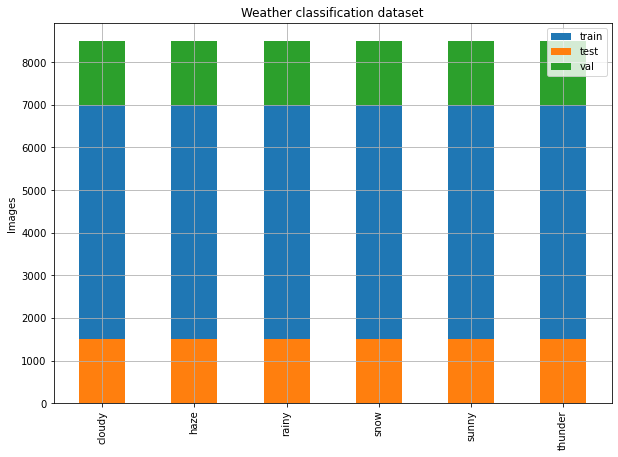

In [13]:
class_counter = {'train': [list(y_train).count(idx) for idx in range(len(classes))], 
                'test': [list(y_test).count(idx) for idx in range(len(classes))],
                'val': [list(y_val).count(idx) for idx in range(len(classes))]}

import matplotlib.pyplot as plt


y1 = class_counter['train']
y2 = class_counter['test']
y3 = class_counter['val']

bar_width = 0.5

plt.figure(figsize=(10, 7))
plt.grid()
plt.bar(classes, y1, label='train', width=bar_width)
plt.bar(classes, y2, label='test', width=bar_width)
plt.bar(classes, y3,bottom=y1, label='val', width=bar_width)
plt.xticks(range(len(classes)), classes, rotation=90)
plt.legend(['train', 'test', 'val'])
plt.ylabel('Images')
plt.title('Weather classification dataset')
plt.show()

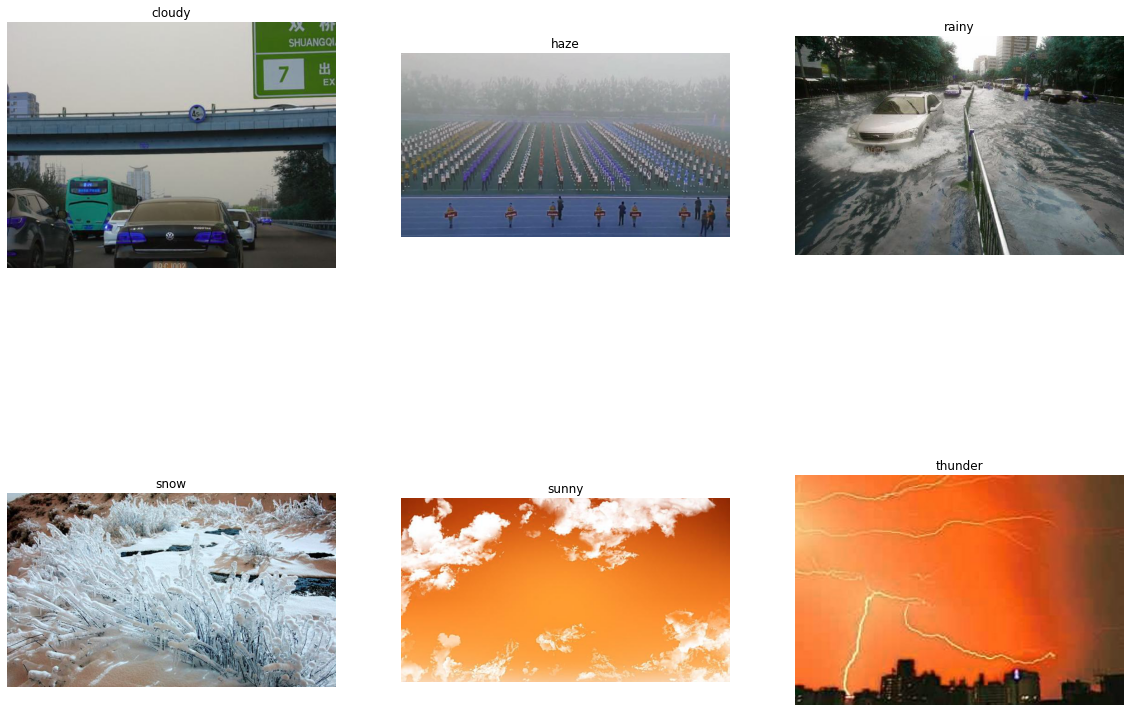

In [14]:
import cv2

%matplotlib inline
plt.figure(figsize=(20, 15))
repr_images = [X_train[list(y_train).index(cls_idx)] for cls_idx in range(len(classes))]

for i, img in enumerate(repr_images):
    plt.subplot(2, 3, i+1)
    cls_name = img.split('_')[0]
    temp_img = cv2.imread(str(data_dir / cls_name / img))
    plt.imshow(temp_img)
    plt.title(cls_name)
    plt.axis('off')

## Convert data to torch format

In [15]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from pathlib import Path
from torchvision import transforms

input_size=(192, 192)

img_transforms = transforms.Compose([
    transforms.Resize(input_size),
])

class CustomDataset(Dataset):
    def __init__(self, annotations:dict, img_dir:Path, transform=None, target_transform=None):
        self.annotations=annotations
        self.img_dir=img_dir
        self.transform=transform
        self.target_transform=target_transform
        self.classes = annotations['classes']
        
    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        img_cat = self.annotations['images'][idx].split('_')[0]
        img_path = str(self.img_dir / img_cat / self.annotations['images'][idx])
        image = read_image(img_path)
        image = image / 255.0
        label = self.classes.index(img_cat)
        if self.transform:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform([label]).to(torch.long)
        return image, label

# Model

## Wybór modelu + summary

In [16]:
from tqdm import tqdm
import timm
import torch
from torchvision import transforms as T
from torch import nn
from torchsummary import summary

In [8]:
device = torch.device('cuda')
model = timm.create_model('tf_efficientnetv2_b0', pretrained=True, num_classes=len(classes))
model.to(device)
summary(model, (3, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1           [-1, 32, 96, 96]             864
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              SiLU-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 16, 96, 96]           4,608
       BatchNorm2d-5           [-1, 16, 96, 96]              32
              SiLU-6           [-1, 16, 96, 96]               0
         ConvBnAct-7           [-1, 16, 96, 96]               0
        Conv2dSame-8           [-1, 64, 48, 48]           9,216
       BatchNorm2d-9           [-1, 64, 48, 48]             128
             SiLU-10           [-1, 64, 48, 48]               0
         Identity-11           [-1, 64, 48, 48]               0
           Conv2d-12           [-1, 32, 48, 48]           2,048
      BatchNorm2d-13           [-1, 32, 48, 48]              64
     EdgeResidual-14           [-1, 32,

## Freezed model + summary

In [9]:
total = len([1 for _ in model.parameters()])

for i,param in enumerate(model.parameters()):
    if i>=(total-2):
        param.requires_grad = True
    else:
        param.requires_grad = False
        
summary(model,(3, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1           [-1, 32, 96, 96]             864
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              SiLU-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 16, 96, 96]           4,608
       BatchNorm2d-5           [-1, 16, 96, 96]              32
              SiLU-6           [-1, 16, 96, 96]               0
         ConvBnAct-7           [-1, 16, 96, 96]               0
        Conv2dSame-8           [-1, 64, 48, 48]           9,216
       BatchNorm2d-9           [-1, 64, 48, 48]             128
             SiLU-10           [-1, 64, 48, 48]               0
         Identity-11           [-1, 64, 48, 48]               0
           Conv2d-12           [-1, 32, 48, 48]           2,048
      BatchNorm2d-13           [-1, 32, 48, 48]              64
     EdgeResidual-14           [-1, 32,

# TensorBoard

In [35]:
%load_ext tensorboard
%tensorboard --logdir logs/weather_classification

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Training

In [17]:
from datetime import datetime
from torch.utils import tensorboard
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

In [29]:
def torch_train(model, optimizer, early_stopping: bool, epochs: int, 
                batch_size: int, model_name, train_dataset, val_dataset,
                patience=3, save_models=False):
    """Trains torch model"""
    device = torch.device('cuda')
    print(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                           num_workers=2)


    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    current_patience = 0
    highest_acc = 0
    
    progress_bar = tqdm(list(range(1, epochs + 1)))
    for epoch in progress_bar:
        if epoch > 1:
            progress_bar.set_description('Val loss: {:.4f}, val acc: {:.4f}'.format(val_loss, val_acc))
        
        model.train()
        train_loss=0
        correct=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().detach()
            train_loss+=loss.detach()
            
        train_loss/=len(train_loader)
        acc = correct / float(len(train_loader.dataset))
        train_losses.append(train_loss)
        train_accs.append(acc)
        
        # log scalars to Tensorboard
        writer.add_scalar('train/acc', acc, epoch)
        writer.add_scalar('train/loss', train_loss, epoch)
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += nn.CrossEntropyLoss()(output, target).sum().detach()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().detach()


        val_loss /= len(val_loader.dataset)
        val_acc = correct / float(len(val_loader.dataset))
        
         #log scalars to Tensorboard
        writer.add_scalar('val/acc', val_acc, epoch)
        writer.add_scalar('val/loss', val_loss, epoch)
        
        # early stopping
        if early_stopping:
            if val_acc > highest_acc:
                highest_acc = val_acc
                current_patience = 0
                
            if len(val_accs) > 0:
                if val_acc < highest_acc:
                    current_patience += 1
                    if current_patience == patience:
                        print(f'Early stopped at {epoch} epoch. Current val_acc: {val_acc}. Last val_acc: {val_accs[-1]}')
                        break
                        
        if save_models:
            if len(val_accs) > 0:
                if val_acc > max(val_accs):
                    torch.save(model.state_dict(), f'./{model_name}_{epoch}_epoch.pt')
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    # log metrics and params to TensorBoard HParams
    writer.add_hparams({'model_name': model_name,
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'params_count': sum(p.numel() for p in model.parameters()),
                       'lr': optimizer.param_groups[0]['lr']},
                       {'hp/train_acc': acc,
                        'hp/val_acc': val_acc},
                       run_name=unique_name)
        
    return model

## Finding best lr

In [18]:
min_lr=1e-4
max_lr=0.01
epochs=15
steps=(epochs-1)*len(train_loader)
lr_lambda = lambda epoch: min_lr * 10**((np.log10(max_lr)-np.log10(min_lr)) * (epoch) / float(steps))

In [116]:
device = torch.device('cuda')
model = timm.create_model('tf_efficientnetv2_b0', pretrained=True, num_classes=len(classes))
model.to(device)

total = len([1 for _ in model.parameters()])

for i,param in enumerate(model.parameters()):
    if i>=(total-2):
        param.requires_grad = True
    else:
        param.requires_grad = False

def find_best_lr(model, min_lr, max_lr, epochs, batch_size):
    
    train_dataset = CustomDataset(annotations['train'], 
                             img_dir=data_dir, 
                             transform=img_transforms)

    val_dataset = CustomDataset(annotations['val'], 
                             img_dir=data_dir, 
                             transform=img_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    steps=(epochs-1)*len(train_loader)
    lr_lambda = lambda epoch: min_lr * 10**((np.log10(max_lr)-np.log10(min_lr)) * (epoch) / float(steps))
    lrs_losses=[]
    optimizer = optim.Adam(model.parameters(), lr=1)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    losses=[]
    lrs=[]
    progress_bar = tqdm(list(range(1, epochs + 1)))

    for epoch in progress_bar:
        if epoch > 1:
            progress_bar.set_description('Val Loss: {:.3f} at LR: {:.6f}'.format(val_loss, lr[0]))
        lr=scheduler.get_last_lr()
        lrs.append(lr[0])
        model.train()
        train_correct=0
        epoch_loss=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            epoch_loss+=loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        val_accs = []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += nn.CrossEntropyLoss()(output, target).sum().detach()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().detach()


            val_loss /= len(val_loader.dataset)
            val_acc = correct / float(len(val_loader.dataset))
            val_accs.append(val_acc)

        epoch_loss /= len(train_loader.dataset)
        losses.append(val_loss)
    losses2 = [_.cpu() for _ in losses]
    accs = [_.cpu() for _ in val_accs]
    print('Best val loss: {:.3f} at LR: {:.6f}'.format(np.min(losses2), lrs[losses2.index(np.min(losses2))]))
    return lrs[losses2.index(np.min(losses2))]

## Training freezed model

In [31]:
# unique_name=datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

writer = tensorboard.SummaryWriter('./logs/weather_classification/EffNetV2_pretrained_freezed')

device = torch.device('cuda')
model = timm.create_model('tf_efficientnetv2_b0', pretrained=True, num_classes=len(classes))
model.to(device)

total = len([1 for _ in model.parameters()])

for i,param in enumerate(model.parameters()):
    if i>=(total-2):
        param.requires_grad = True
    else:
        param.requires_grad = False

train_dataset = CustomDataset(annotations['train'], 
                             img_dir=data_dir, 
                             transform=img_transforms)

val_dataset = CustomDataset(annotations['val'], 
                             img_dir=data_dir, 
                             transform=img_transforms)

optimizer = optim.Adam(model.parameters(), lr=0.000373)

model = torch_train(model, optimizer, early_stopping=True, epochs=30, patience=4, batch_size=64, 
                    model_name='effnetv2_pretrained', train_dataset=train_dataset, val_dataset=val_dataset
                   save_mod)

cuda


Val loss: 0.0112, val acc: 0.7291: 100%|██████████| 15/15 [23:56<00:00, 95.75s/it]


### Longer training

In [32]:
writer = tensorboard.SummaryWriter('./logs/weather_classification/EffNetV2_pretrained_freezed_v2')

model = torch_train(model, optimizer, early_stopping=True, epochs=20, patience=4, batch_size=64, 
                    model_name='effnetv2_pretrained', train_dataset=train_dataset, val_dataset=val_dataset)

cuda


Val loss: 0.0106, val acc: 0.7399:  20%|██        | 4/20 [08:05<32:21, 121.34s/it]

Early stopped at 5 epoch. Current val_acc: 0.7279093265533447. Last val_acc: 0.739913284778595


## Unfreezed model fine tuning

In [ ]:
model2 = model
# unique_name=datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

writer = tensorboard.SummaryWriter('./logs/weather_classification/EffNetV2_pretrained_unfreezed')
# model = timm.create_model('tf_efficientnetv2_b0', pretrained=False, num_classes=len(classes))

total = len([1 for _ in model2.parameters()])

for i,param in enumerate(model2.parameters()):
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.0002)
model = torch_train(model2, optimizer, early_stopping=True, epochs=20, batch_size=64, patience=4, 
                    model_name='effnetv2_pretrained_unfreezed', train_dataset=train_dataset, 
                    val_dataset=val_dataset)

## Training non-pretrained model from scratch

In [16]:
unique_name=datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

writer = tensorboard.SummaryWriter('./logs/weather_classification/'+unique_name)

device = torch.device('cuda')
model = timm.create_model('tf_efficientnetv2_b0', pretrained=False, num_classes=len(classes))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.000373)

model = torch_train(model, optimizer, early_stopping=True, epochs=15, patience=4, batch_size=64, model_name='effnetv2_scratch')

cuda


Val loss: 0.0169, val acc: 0.7096:  80%|████████  | 12/15 [53:51<13:27, 269.28s/it] 

Early stopped at 13 epoch. Current val_acc: 0.7103478908538818. Last val_acc: 0.7095698714256287


In [22]:
from PIL import Image
results = Image.open('results.png')

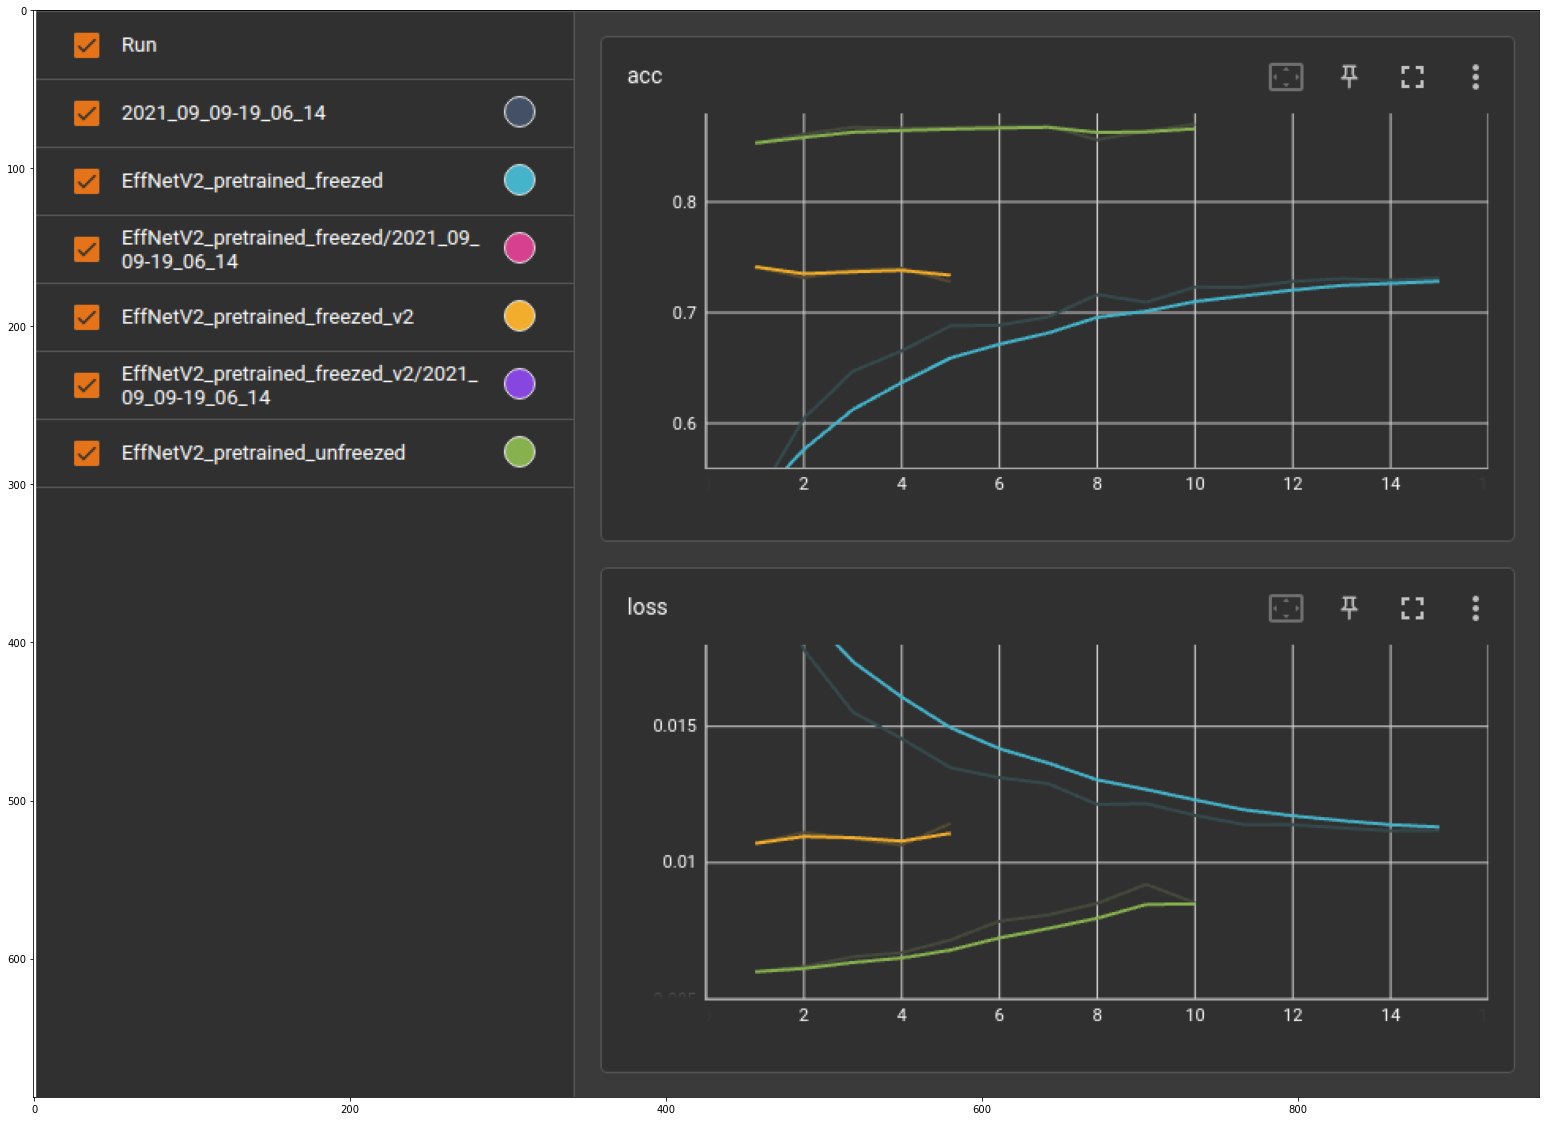

In [24]:
%matplotlib inline
plt.figure(figsize=(30, 20))
plt.imshow(results)

# Summmary / extra

In [14]:
# torch.save(model2.state_dict(), 'best_model.pth')

test_model = timm.create_model('tf_efficientnetv2_b0', pretrained=False, num_classes=len(classes))
test_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [18]:
test_dataset = CustomDataset(annotations['test'], 
                             img_dir=data_dir, 
                             transform=img_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### Model test on unseen data

In [26]:
device = torch.device('cuda')
test_model.to(device)

test_model.eval()
results = []
labels = []

correct = 0
acc = 0
wrong = []


with torch.no_grad():
    progress_bar = tqdm(list(test_loader))
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        out = test_model(data)
        results.append(out)
        labels.append(target)
        correct += torch.count_nonzero(torch.max(out, dim=1)[1].eq(target))
        predictions = torch.max(out, dim=1)[1]
        wrong_idxs = (~torch.max(out, dim=1)[1].eq(target)).nonzero()
        progress_bar.set_description('Test accuracy: {:.2f}%'.format(100*(correct / ((batch_idx+1)*64)).cpu().numpy()))
        for idx in wrong_idxs:
            wrong.append((data[idx], target[idx], predictions[idx]))

Test accuracy: 86.05%: 100%|██████████| 141/141 [00:13<00:00, 10.28it/s]


### Confusion Matrix

In [54]:
results2 = [torch.max(_, dim=1)[1].cpu().numpy() for _ in results]
labels2 = [_.cpu().numpy() for _ in labels]

labels2 = np.hstack(labels2)
results2 = np.hstack(results2)

Text(0.5, 1.0, 'Weather Classification Confusion Matrix')

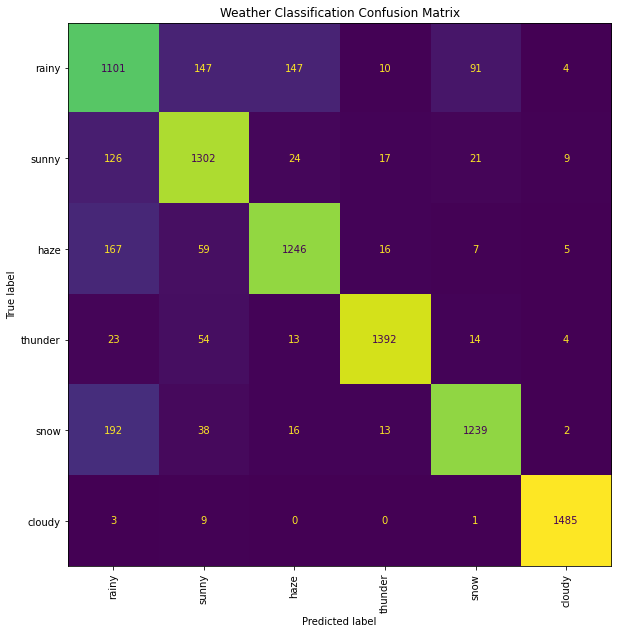

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels2, results2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(xticks_rotation='vertical', ax=ax, colorbar=False)
ax.set_title('Weather Classification Confusion Matrix')

### Some mistakes

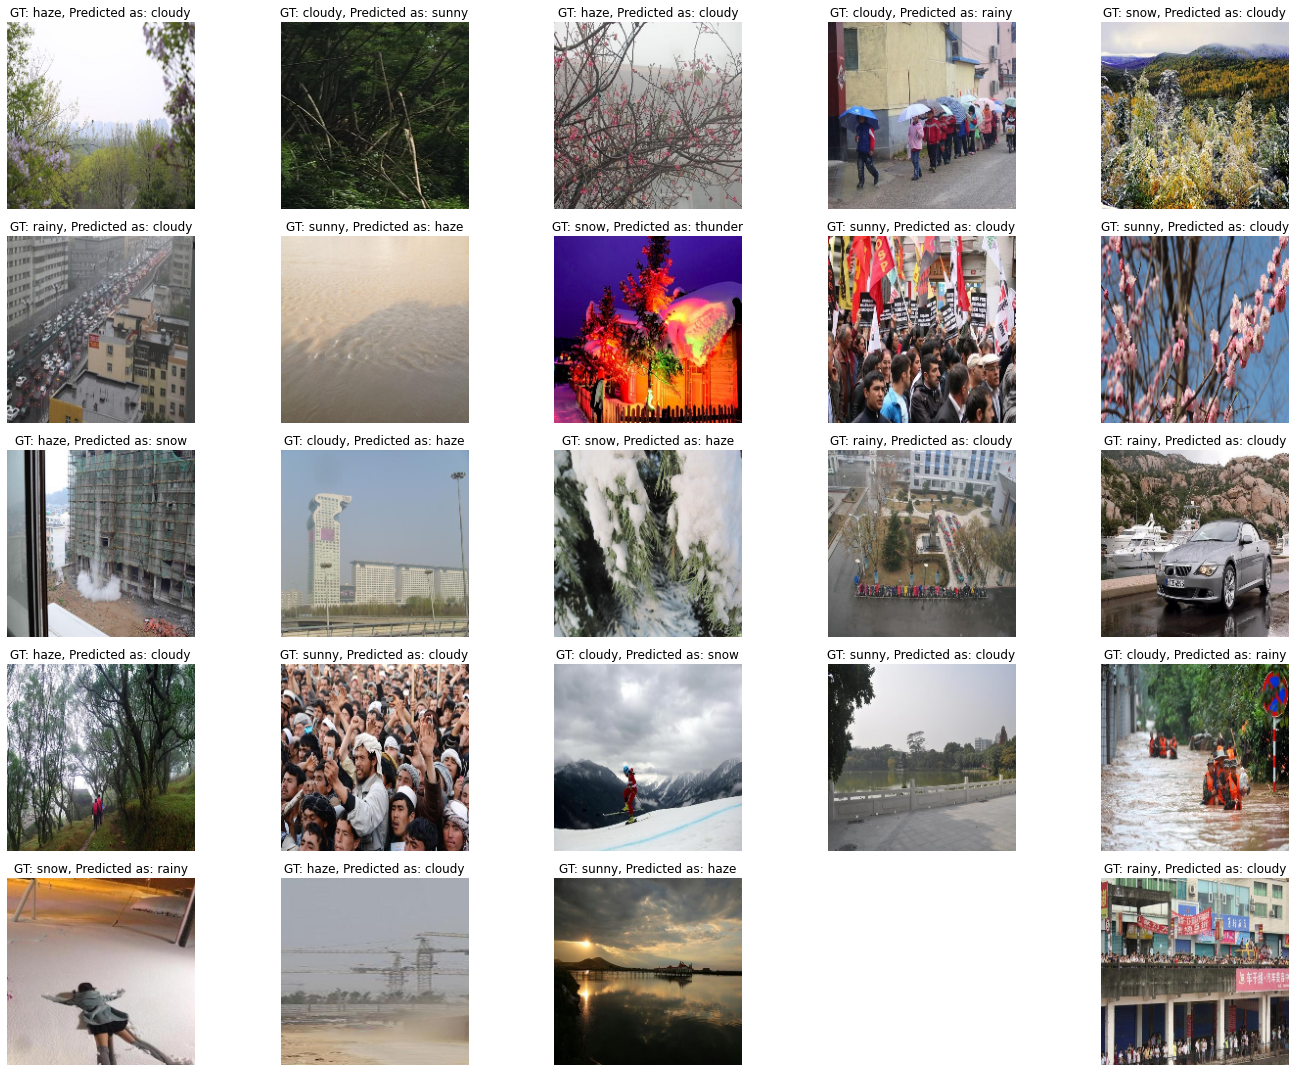

In [81]:
plt.figure(figsize=(20, 15))


for i, (img, label,pred) in enumerate(wrong[:25]):
    plt.subplot(5, 5, i+1)
    plt.imshow(img.cpu().numpy().squeeze().transpose(1, 2, 0))
    plt.title(f'GT: {classes[int(label)]}, Predicted as: {classes[pred]}')
    plt.axis('off')
    plt.tight_layout()

## Trying MobileNetV2

In [25]:
import torchvision.models as models

device = torch.device('cuda')

mobilenet_v2 = models.mobilenet_v2(pretrained=True)

mobilenet_v2.to(device)
summary(mobilenet_v2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### New classifier

In [26]:
mobilenet_v2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=len(classes), bias=True)
)
mobilenet_v2.to(device);
summary(mobilenet_v2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### Freezing model

In [27]:
total = len([1 for _ in mobilenet_v2.parameters()])


for i, param in enumerate(mobilenet_v2.parameters()):
    if i>=(total-2):
        param.requires_grad = True
    else:
        param.requires_grad = False
summary(mobilenet_v2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### Finding best lr

In [119]:
best_lr = find_best_lr(model=mobilenet_v2, min_lr=1e-4, max_lr=1e-1, epochs=15, batch_size=64)

Val Loss: 0.447 at LR: 0.061054: 100%|██████████| 15/15 [58:05<00:00, 232.37s/it]

Best val loss: 0.011 at LR: 0.000268


### Freezed model training

In [31]:
unique_name=datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

writer = tensorboard.SummaryWriter('./logs/weather_classification/mobilenetv2_pretrained_freezed')

input_size=(224, 224)

img_transforms = transforms.Compose([
    transforms.Resize(input_size),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(annotations['train'], 
                             img_dir=data_dir, 
                             transform=img_transforms)

val_dataset = CustomDataset(annotations['val'], 
                             img_dir=data_dir, 
                             transform=img_transforms)

optimizer = optim.Adam(mobilenet_v2.parameters(), lr=0.0004)

model = torch_train(mobilenet_v2, optimizer, early_stopping=True, epochs=30, patience=4, 
                    batch_size=64, model_name='mobilenetv2_pretrained_freezed',
                    train_dataset=train_dataset, val_dataset=val_dataset,
                   save_models=True)

cuda


Val loss: 0.0095, val acc: 0.7628:  47%|████▋     | 14/30 [29:24<33:36, 126.03s/it]

Early stopped at 15 epoch. Current val_acc: 0.7598088383674622. Last val_acc: 0.7628098130226135


### Unfreezed model training

In [32]:
for i, param in enumerate(model.parameters()):
    param.requires_grad = True

In [ ]:
writer = tensorboard.SummaryWriter('./logs/weather_classification/mobilenetv2_pretrained_unfreezed')

optimizer = optim.Adam(model.parameters(), lr=0.0003)

model = torch_train(model, optimizer, early_stopping=True, epochs=30, patience=4, 
                    batch_size=64, model_name='mobilenetv2_pretrained_unfreezed',
                    train_dataset=train_dataset, val_dataset=val_dataset)

#Val loss: 0.0093, val acc: 0.8353:  27%|██▋       | 8/30 [42:13<1:56:06, 316.68s/it] -> Early stopped

## Summary

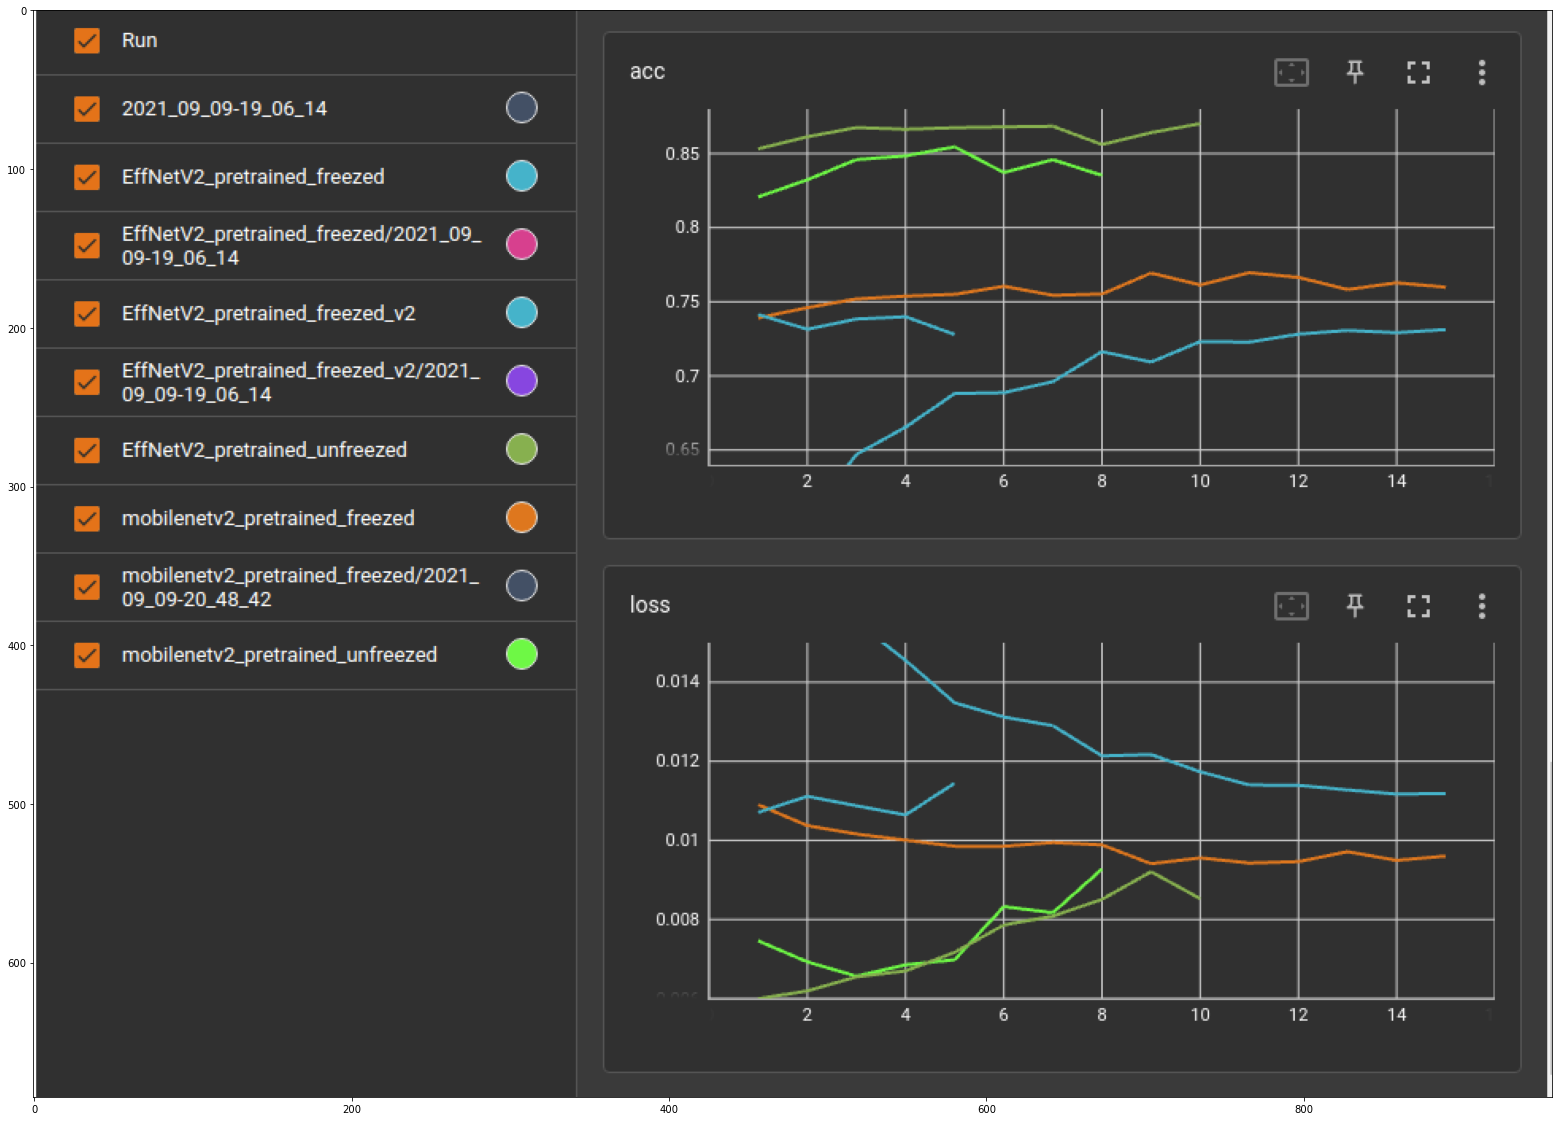

In [36]:
summary = Image.open('results2.png')
plt.figure(figsize=(30, 20))
plt.imshow(summary)

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.